<a href="https://colab.research.google.com/github/sdgroeve/Machine_Learning_course_UGent_D012554_2023/blob/main/notebooks/4_tree_ensembles/4.3%20bagging%20-%20boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TREE ENSEMBLES

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style("whitegrid")

from sklearn import set_config
set_config(transform_output = "pandas")

In [ ]:
###util methods
plot_colors = "br"
plot_step = 0.02
class_names = "AB"
def plot_ensemble(bdt,X,y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis("tight")
    # Plot the training points
    for i, n, c in zip(range(2), class_names, plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                s=20, edgecolor='k',
                label="Class %s" % n)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(loc='upper right')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Decision Boundary')

In the previous chapter about bias and variance we have seen that averaging the predictions of several low bias, high variance models each trained on different training set samples reduces the variance of the combined model (known as an **ensemble** or **meta-model**) while preserving a low bias.

## bagging

A popular ensemble based learning algorithm that exploits this observation is the **Random Forest** learning algorithm. It computes an ensemble of complex (deep) decision trees (which are known to have low bias but high variance) by implementing what is called **boostrap aggregation (or bagging)**.   

The Random Forest learning algorithm trains $T$ decision trees $f_t(x,\theta)$ each on a random subset of the training set and then averages the predictions of each model according to:

<br>
$$\hat{f}(x,\theta) = \frac{1}{T} \sum_{t=1}^T f_t(x,\theta)$$
<br>

where $f_t$ is the $t^{th}$ tree. 

The Random Forest model consists essentially of bootstrap aggregated decision trees, where the bagging takes place at the level of the samples **and** the features. The learning algorithm for fitting a Random Forest model works as follows:

Let $n$ be the number of data points and $m$ the number of features in the training set. Construct $T$ decision trees by following these steps:

1. Sample $n$ data points at random - but **with replacement**, from the training set. These will be the training feature vectors for growing the tree. 

2. If there are $m$ features, a number $h<<m$ is specified such that at each node, $h$ features are selected at random out of the $m$ features and the best split on these $h$ is used to split the node. The value of $h$ is held constant during the forest growing.
 
3. Each tree is grown to the **largest extent possible**. There is no pruning or early stopping. 

Step 3 ensures that the bagged models are low bias by learning deep complex decision trees.
<br>

To illustrate the impact of averaging models trained on bagged train sets we consider the following two class classification task:

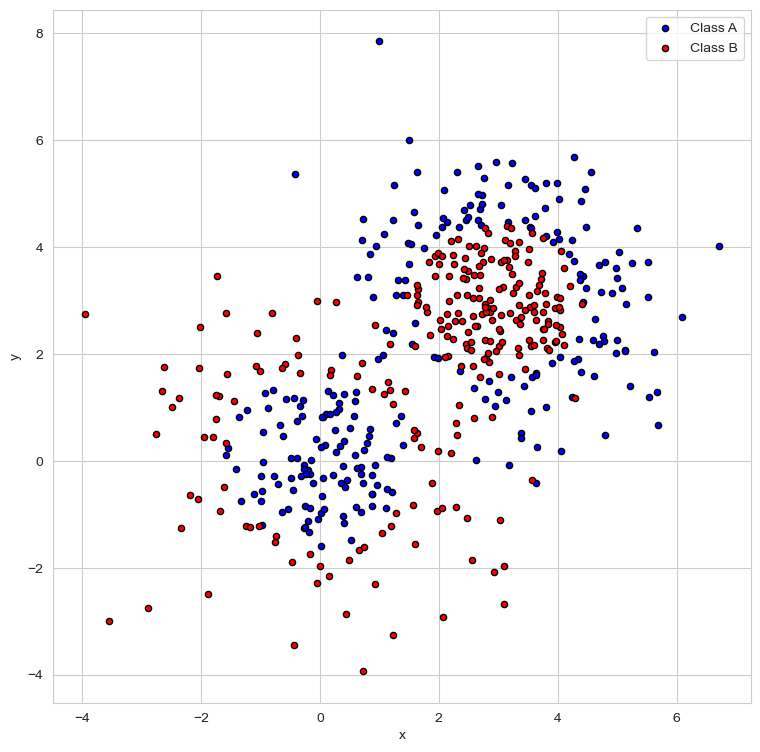

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_data/master/notebooks/6_ensemble_learning/dataset.csv")
y = data.pop("y")
X = data.values

plt.figure(figsize=(9,9))
for i, n, c in zip(range(2), "AB", "br"):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
            c=c, cmap=plt.cm.Paired,
            s=20, edgecolor='k',
            label="Class %s" % n)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We fit Random Forest meta-models to this data set for an increasing number of $T$ (usign the `RandomForestClassifier` function in scikit-learn):

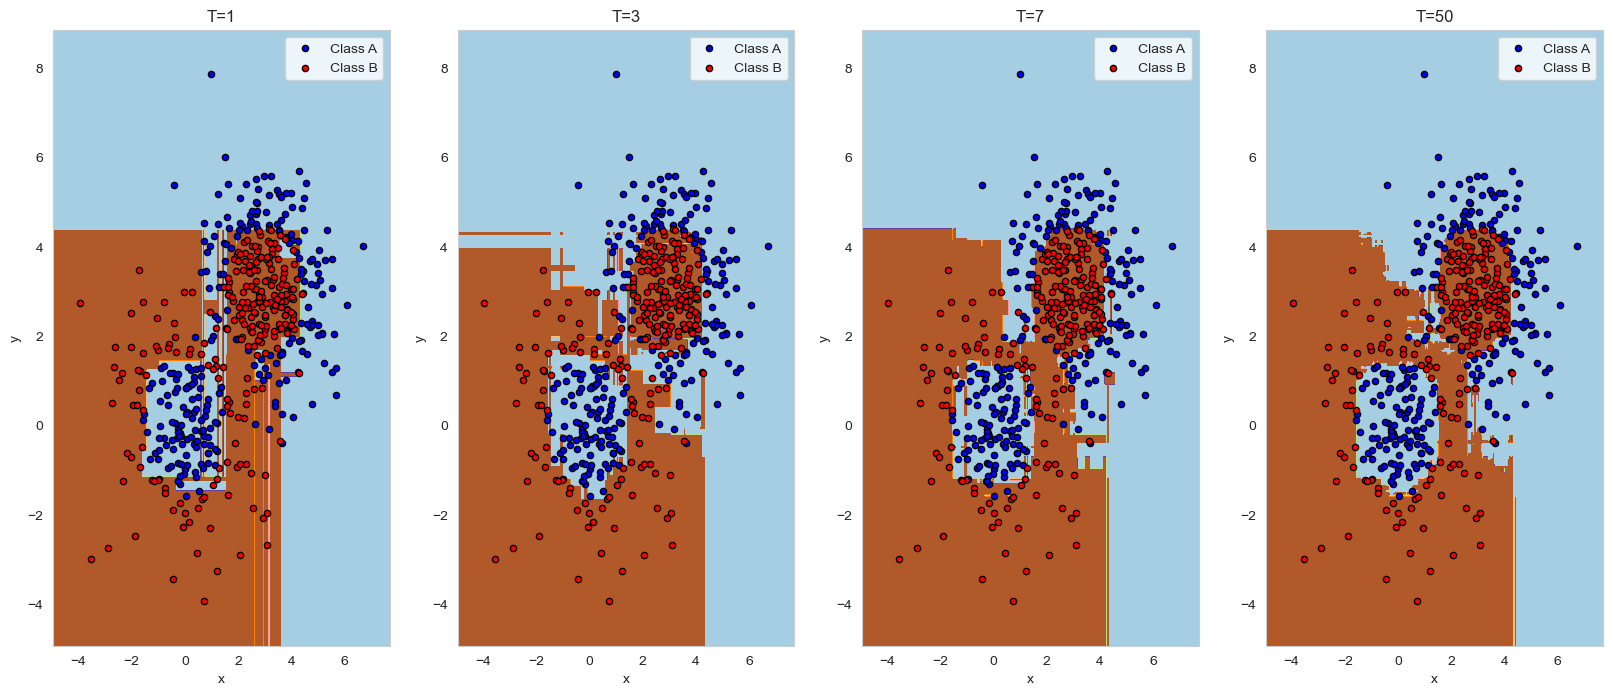

In [ ]:
from sklearn.ensemble import RandomForestClassifier

plt.figure(figsize=(20, 8))
plt.subplot(1,4,1)
bdt = RandomForestClassifier(n_estimators=1)
bdt.fit(X, y)
plot_ensemble(bdt,X,y)   
plt.title("T=1")
plt.subplot(1,4,2)
bdt = RandomForestClassifier(n_estimators=3)
bdt.fit(X, y)
plot_ensemble(bdt,X,y)   
plt.title("T=3")
plt.subplot(1,4,3)
bdt = RandomForestClassifier(n_estimators=7)
bdt.fit(X, y)
plot_ensemble(bdt,X,y)   
plt.title("T=7")
plt.subplot(1,4,4)
bdt = RandomForestClassifier(n_estimators=50)
bdt.fit(X, y)
plot_ensemble(bdt,X,y)   
plt.title("T=50")
plt.show()

The meta-model classifies all test data points in the blue region as class A (blue) and all test points in the brown region as class B (red). The meta-model with $T=50$ will show better generalization performance than with $T=1$. 

In the chapter about decision trees we estimated the expected generalization performance of an optimized decision tree on the TIS dataset. The following code estimates the generalization performance of the Random Forest meta-model:

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import metrics

dataset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_data/master/notebooks/6_ensemble_learning/TISs.csv",sep=";")

X = dataset.loc[:,dataset.columns!="label"]
y = dataset.loc[:,"label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier()

search_space = {'n_estimators':[10,20,50], 
                'max_features':[3,7,11,17]}

grid_search = GridSearchCV(model, param_grid=search_space, cv=10)

grid_search.fit(X_train,y_train)

print(grid_search.best_estimator_)
print(grid_search.best_score_)

predictions_test = grid_search.best_estimator_.predict(X_test)
print("accuracy on test set: {:.2f}".format(metrics.accuracy_score(y_test,predictions_test)))

RandomForestClassifier(max_features=7, n_estimators=50)
0.8555861131634878
accuracy on test set: 0.85


You should observe better estimated performance.

A decision tree intrinsically computes feature importances by selecting appropriate split points. This information can be exploited to measure the importance of a feature in a decision tree: the more often a feature is used in the split points of a decision tree the more important that feature is. 

This notion of importance can be extended to decision tree ensembles by simply averaging the feature importance of each tree. In scikit-learn these feature importances are computed while fitting a model and are available through the `feature_importances_` property of a model:

In [ ]:
best_model = grid_search.best_estimator_

for f_name, f_importance in zip(best_model.feature_names_in_,best_model.feature_importances_):
    print("{}\t{}".format(f_name,f_importance))

UP_A	0.05294345371547953
DOWN_A	0.06107262249253439
UP_R	0.03417002479734668
DOWN_R	0.022873610401002945
UP_N	0.010042980320723807
DOWN_N	0.02285258621627784
UP_D	0.011489369283580438
DOWN_D	0.052036676788973016
UP_C	0.00923940022051168
DOWN_C	0.015605158938141177
UP_Q	0.011480721812411929
DOWN_Q	0.021257722948733165
UP_E	0.018641234609633038
DOWN_E	0.05579144996201147
UP_G	0.03807455797823084
DOWN_G	0.03923908973506525
UP_H	0.008367122993481363
DOWN_H	0.013772675162918134
UP_I	0.010628978912158183
DOWN_I	0.028736242890170918
UP_L	0.02327872664904188
DOWN_L	0.06342680395410559
UP_K	0.015226477041799056
DOWN_K	0.028996028924699133
UP_M	0.0
DOWN_M	0.012344586054043639
UP_F	0.013059319096440852
DOWN_F	0.027961691142928444
UP_P	0.030253544029701426
DOWN_P	0.023347898792932704
UP_S	0.03069983705849002
DOWN_S	0.031239467806552977
UP_T	0.018169839521093117
DOWN_T	0.021933363269283607
UP_W	0.006781632855458789
DOWN_W	0.012113653045652035
UP_Y	0.005984630194636139
DOWN_Y	0.021323274963385548
UP

## boosting

The Random Forest learning algorithm reduces the variance of a low bias high, variance decision tree model. We can also reduce the bias of a high bias, low variance model using a technique called **boosting**. 

The idea is to transform an ensemble of low complex (high bias) models into a high complex (low bias) meta-model. In the context of boosting we talk about turning an ensemble of weak learners into a strong learner. 

A well known example is the **adaboost** learning algorithm. It computes a meta-model of the form:

<br>
$$\hat{f}(x,\theta) = \sum_{t=1}^T \alpha_t f_t(x,\theta).$$
<br>

Note that this is an **additive** model where the predictions of each weak model are summed (not averaged as with bagging) to compute the final prediction.

Adaboost computes a strong classifier from an ensemble of weak classifiers as follows.

Let $n$ be the number of data points in the training set. Each data point $(x_i,y_i)$ with $x_i \in X$ and $y_i \in \{-1,1\}$ is assigned a weight $D(i)$. This weight is used by the weak classifier in the loss function to increase or decrease the contribution of a data point $x_i$ to the overal cost.

Initialize the weights $D_1(i) = 1/n$, $i = 1, 2, \dots, n$.

For $t = 1$ to $T$:
      
1. Fit a weak classifier $f_t(x,\theta)$ to the training data using weights $D_1(i)$.

2. Set $\alpha_t = \frac{1}{2} ln(\frac{1-error}{error})$.

3. Update weights:

<br>
$$D_{t+1}(i)=\frac{D_t(i)exp({-\alpha_t y_i f_t(x_i,\theta)})}{Z_t},$$ 
<br>

where $Z_t$ is a normalizing factor that makes sure that $\sum{D_{t+1}(i)}=1$.

The $\alpha_t$ weights each model in the meta-model by the error it makes. Below the value of $\alpha$ is plotted against the error rate of a weak classifier:

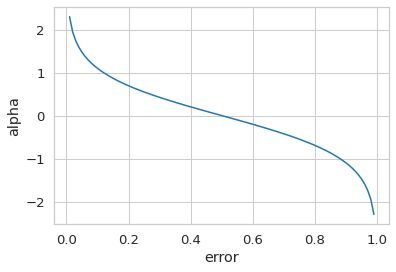

In [ ]:
x = np.arange(start=0.01,stop=1,step=0.01)
y = 0.5 * np.log((1-x)/x)
plt.plot(x,y)
plt.xlabel("error")
plt.ylabel("alpha")
plt.show()

There are three bits of intuition to take from this graph:

- The weight $\alpha_t$ of a weak model $f_t(x_i,\theta)$ in the boosted meta-model increases exponentially as the error approaches 0. Better models are given exponentially more weight.

- The weight is zero if the error rate is 0.5. A model with 50% accuracy is no better than random guessing, so it is  ignored.

- The weight decreases exponentially as the error approaches 1. A negative weight is given to classifiers with worse than 50% accuracy. “Whatever that classifier says, do the opposite!”.

A typical weak classifier for adaboost is again a decision tree. However this time we want the decision tree learning algorithm to compute high bias, low variance trees (we need weak learners). This is for instance achieved by severely limiting the depth of the decision trees that are constructed.

The following code shows how the decision boundary of a boosted decision tree with just one split improves as the number of these weak trees in the meta-model increases:

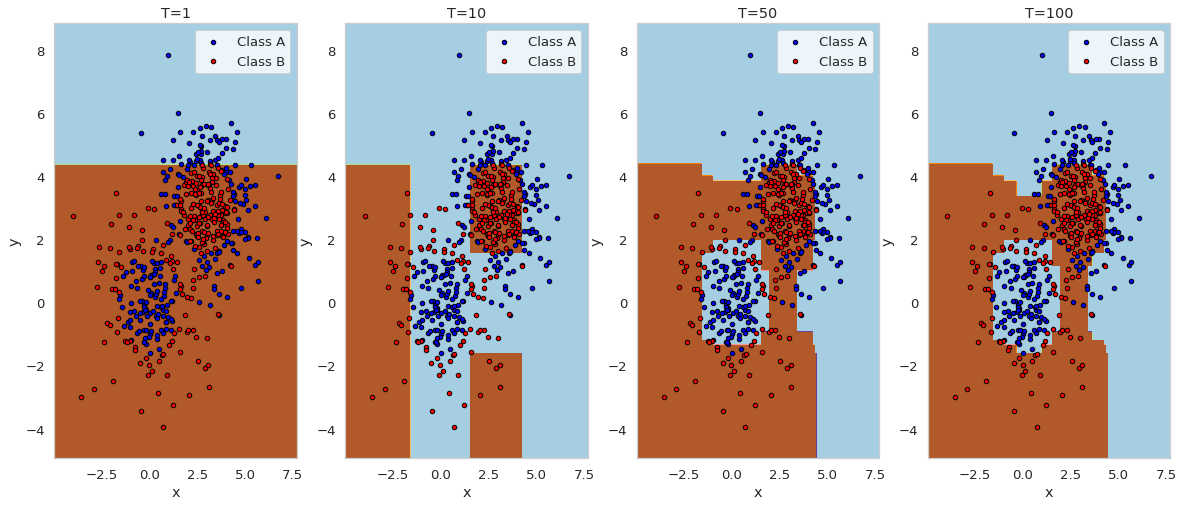

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_data/master/notebooks/6_ensemble_learning/dataset.csv")
y = data.pop("y")
X = data.values

plt.figure(figsize=(20, 8))
plt.subplot(1,4,1)
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME",n_estimators=1)
bdt.fit(X, y)
plot_ensemble(bdt,X,y)   
plt.title("T=1")
plt.subplot(1,4,2)
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME",n_estimators=10)
bdt.fit(X, y)
plot_ensemble(bdt,X,y)   
plt.title("T=10")
plt.subplot(1,4,3)
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME",n_estimators=50)
bdt.fit(X, y)
plot_ensemble(bdt,X,y)   
plt.title("T=50")
plt.subplot(1,4,4)
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME",n_estimators=100)
bdt.fit(X, y)
plot_ensemble(bdt,X,y)   
plt.title("T=100")
plt.show()

In Adaboost the "shortcommings" of a weak learner are identified by high-weight data points. 

In a more recent approach to boosting, called **Gradient Boosting**, the "shortcommings" are identified by gradients.  

Gradient Boosting computes a strong classifier

$$\hat{f}(x,\theta) = \sum_{t=1}^T f_t(x,\theta),$$

from an ensemble of weak classifiers as follows.

1. Fit a model $f_1(x,\theta) = y$
2. Fit a model to the **residuals** $h_1(x) = y - f_1(x,\theta)$
3. Create a new model $f_2(x,\theta) = f_1(x,\theta)+h_1(x)$

We can then repeat steps 2 and 3 to compute a new model $f_3(x,\theta)$ that corrects the errors (residuals) of the previous model. This leads to a recursive procedure that can be make more mathematically consistent by introducing a model 

<br>
$$f_0(x,\theta) = \frac{1}{n}\sum_{i=1}^{n}{y_i}.$$
<br>

So $f_0$ predicts the average value of the label in the train set for each data point $x$.

Now we can define each subsequent $f_t$ recursively:

<br>
$$f_{t+1}(x,\theta) = f_{t}(x,\theta) + h_{t}(x),$$
<br>

where $h_{t}(x)$ is a (weak) learner.